In [1]:
import os
import tempfile
import torch
from pathlib import Path

from csv import writer
from torch.utils.data import DataLoader
from tqdm import trange, tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

from data_utils.csv_dataloader import create_csv_flowpic_loader
from models.configurable_cnn import ConfigurableCNN
from training.trainer import train_model
from training.utils import set_seed, save_config_to_json
from config import Config


In [2]:
label_whitelist = [386,  497,  998,  171,  485, 2613,  340,  373,  561,  967,  436, 1088,
        961,  682,  521,  964, 1450, 1448,  965, 42]
apps_id_df = pd.read_csv('/home/anatbr/dataset/Allot/ver02 - Location 01 - 2024.09.12-17_AppIds G Z.csv', index_col=0)
apps_id_df = apps_id_df[apps_id_df.index.isin(label_whitelist)]
label_mapping = {row['names']: i for i, row in apps_id_df.reset_index().iterrows()}
label_indices_mapping = {label_index: new_label_index for
                         new_label_index, (label_index, row)
                         in enumerate(apps_id_df.iterrows())
                         if label_index in label_whitelist}

num_classes = len(label_mapping)
cfg = Config(RESOLUTION=64)


In [3]:
dfs = []
for i in range(0, 70):
    chunk_path = os.path.join('data', 'allot_small_csvs', 'chunks', f'chunk_{i:03}.csv')
    df = pd.read_csv(chunk_path)
    df = df[df['appId'].isin(label_whitelist)]
    dfs.append(df)
df_train = pd.concat(dfs, ignore_index=True)
df_train = df_train.sample(frac=1).reset_index(drop=True)


dfs = []
for i in range(70, 100):
    chunk_path = os.path.join('data', 'allot_small_csvs', 'chunks', f'chunk_{i:03}.csv')
    df = pd.read_csv(chunk_path)
    df = df[df['appId'].isin(label_whitelist)]
    dfs.append(df)
df_test = pd.concat(dfs, ignore_index=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)


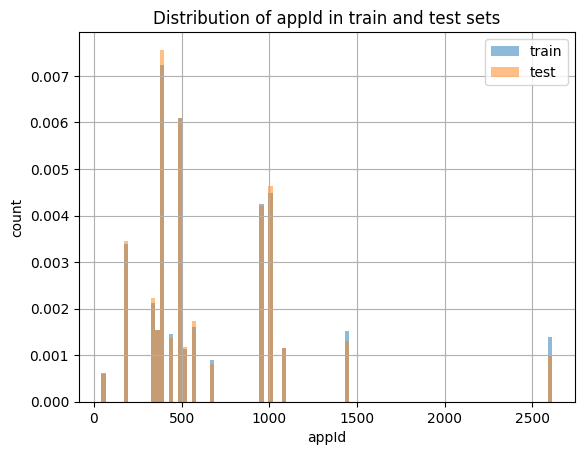

In [7]:
df_train['appId'].hist(bins=100, alpha=0.5, label='train', density=True)
df_test['appId'].hist(bins=100, alpha=0.5, label='test', density=True)
plt.legend()
plt.xlabel('appId')
plt.ylabel('count')
plt.title('Distribution of appId in train and test sets')
plt.show()

In [5]:
train_loader = create_csv_flowpic_loader([df_train], batch_size=64, num_workers=0,
                                        shuffle=False, resolution=64,
                                        label_mapping=label_indices_mapping, log_t_axis=False) 

cfg.MODEL_PARAMS['num_classes'] = num_classes
model = ConfigurableCNN(cfg.MODEL_PARAMS).to(cfg.DEVICE)

optimizer = optim.Adam(model.parameters(), lr=cfg.LEARNING_RATE)
criterion = nn.CrossEntropyLoss()


experiment_path = cfg.EXPERIMENT_PATH / f"000_to_{i:003d}"
experiment_path.mkdir(parents=True, exist_ok=True)

weights_save_dir = experiment_path / 'weights'
plots_save_dir = experiment_path / 'plots'
weights_save_dir.mkdir(parents=True, exist_ok=True)
plots_save_dir.mkdir(parents=True, exist_ok=True)

save_config_to_json(config_module=cfg, output_file_path=experiment_path / "config.json")

chunk_path = os.path.join('data', 'allot_small_csvs', 'chunks', f'chunk_{i:03d}.csv')
test_loader = create_csv_flowpic_loader([df_test], batch_size=64, num_workers=0,
                                        shuffle=False, resolution=64,
                                        label_mapping=label_indices_mapping, log_t_axis=False)

train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=cfg.NUM_EPOCHS,
    device=cfg.DEVICE,
    weights_save_dir=weights_save_dir,
    plots_save_dir=plots_save_dir,
    label_mapping=label_mapping,
    lambda_mmd=cfg.LAMBDA_MMD,
    mmd_bandwidths=cfg.MMD_BANDWIDTHS,
    lambda_dann=cfg.LAMBDA_DANN,
)

final_model_path = weights_save_dir / f"model_final_000train_to_000test.pth"
torch.save(model.state_dict(), final_model_path)
print(f"Model for train domain train_domain to test domain {i:03d} saved to {final_model_path}")


/home/anatbr/students/noamshakedc/da4etc/data_utils/csv_dataloader.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ppi-pdt'] = df['ppi-pdt'].transform(extract_numbers)
/home/anatbr/students/noamshakedc/da4etc/data_utils/csv_dataloader.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ppi-pd'] = df['ppi-pd'].transform(extract_numbers)
/home/anatbr/students/noamshakedc/da4etc/data_utils/csv_dataloader.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

Epoch 0.0: GRL Lambda = 0.0


Epoch 1: Train Loss=1.0902, Accuracy=66.43%
         Val Loss=0.8547, Accuracy=73.32%
         MMD Loss=0.0000, Regular Loss=1.0902
         DANN Loss=0.0000, Regular Loss=1.0902
Epoch 0.01: GRL Lambda = 0.0004995834897272289


Epoch 2: Train Loss=0.8959, Accuracy=72.12%
         Val Loss=0.7972, Accuracy=74.91%
         MMD Loss=0.0000, Regular Loss=0.8960
         DANN Loss=0.0000, Regular Loss=0.8960
Epoch 0.02: GRL Lambda = 0.0009966790676116943


Epoch 3: Train Loss=0.8515, Accuracy=73.38%
         Val Loss=0.7589, Accuracy=76.13%
         MMD Loss=0.0000, Regular Loss=0.8515
         DANN Loss=0.0000, Regular Loss=0.8515
Epoch 0.03: GRL Lambda = 0.0014888501027598977


Epoch 4: Train Loss=0.8277, Accuracy=74.07%
         Val Loss=0.7382, Accuracy=76.79%
         MMD Loss=0.0000, Regular Loss=0.8277
         DANN Loss=0.0000, Regular Loss=0.8277
Epoch 0.04: GRL Lambda = 0.0019737528637051582


Epoch 5: Train Loss=0.8116, Accuracy=74.61%
         Val Loss=0.7256, Accuracy=77.09%
         MMD Loss=0.0000, Regular Loss=0.8117
         DANN Loss=0.0000, Regular Loss=0.8117
Epoch 0.05: GRL Lambda = 0.002449186984449625


Epoch 6: Train Loss=0.8000, Accuracy=74.90%
         Val Loss=0.7170, Accuracy=77.41%
         MMD Loss=0.0000, Regular Loss=0.8001
         DANN Loss=0.0000, Regular Loss=0.8001
Epoch 0.06: GRL Lambda = 0.002913125790655613


Epoch 7: Train Loss=0.7914, Accuracy=75.15%
         Val Loss=0.7118, Accuracy=77.55%
         MMD Loss=0.0000, Regular Loss=0.7915
         DANN Loss=0.0000, Regular Loss=0.7915
Epoch 0.07: GRL Lambda = 0.0033637546002864838


Epoch 8: Train Loss=0.7823, Accuracy=75.44%
         Val Loss=0.7075, Accuracy=77.66%
         MMD Loss=0.0000, Regular Loss=0.7824
         DANN Loss=0.0000, Regular Loss=0.7824
Epoch 0.08: GRL Lambda = 0.003799489699304104


KeyboardInterrupt: 

In [3]:
cfg.MODEL_PARAMS['num_classes'] = num_classes
model = ConfigurableCNN(cfg.MODEL_PARAMS).to(cfg.DEVICE)

optimizer = optim.Adam(model.parameters(), lr=cfg.LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

train_chunk_path = os.path.join('data', 'allot_small_csvs', 'chunks', 'chunk_000.csv')
train_loader = create_csv_flowpic_loader([train_chunk_path], batch_size=64, num_workers=0, shuffle=False, resolution=64)

In [4]:
test_chunk_path = os.path.join('data', 'allot_small_csvs', 'chunks', f'chunk_{100:03d}.csv')
test_loader_1 = create_csv_flowpic_loader([test_chunk_path], batch_size=64, num_workers=0, shuffle=False, resolution=64, log_t_axis=False)
test_loader_2 = create_csv_flowpic_loader([test_chunk_path], batch_size=64, num_workers=0, shuffle=False, resolution=64, log_t_axis=True)

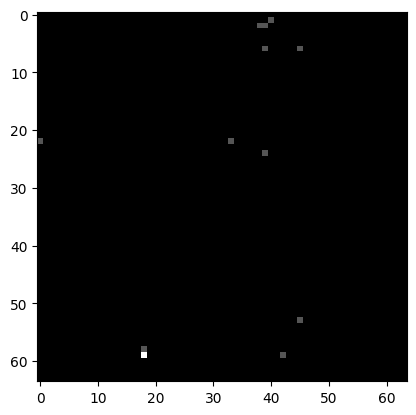

In [34]:
for x, y in test_loader_2:
    plt.imshow(x[np.random.randint(64)].cpu().numpy(), cmap='gray')
    break

In [15]:
train_df = pd.read_csv(train_chunk_path, index_col=0)
test_df = pd.read_csv(test_chunk_path, index_col=0)

In [ ]:
log_t_axis

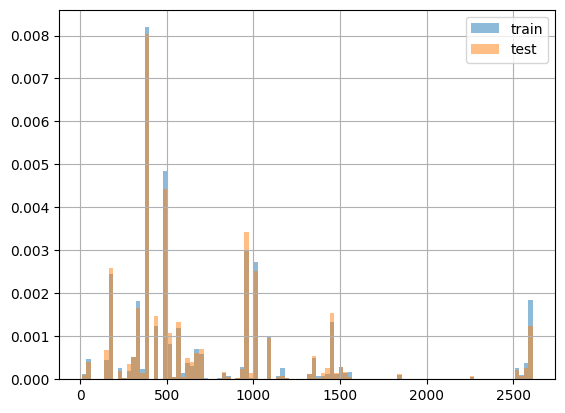

In [16]:
train_df.appId.hist(alpha=0.5, bins=100, density=True, label='train')
test_df.appId.hist(alpha=0.5, bins=100, density=True, label='test')
plt.legend()
plt.show()

In [ ]:
for i in range(0, 200, 100):
    experiment_path = cfg.EXPERIMENT_PATH / "000_to_{i:003d}"
    experiment_path.mkdir(parents=True, exist_ok=True)

    weights_save_dir = experiment_path / 'weights'
    plots_save_dir = experiment_path / 'plots'
    weights_save_dir.mkdir(parents=True, exist_ok=True)
    plots_save_dir.mkdir(parents=True, exist_ok=True)

    save_config_to_json(config_module=cfg, output_file_path=experiment_path / "config.json")
    
    chunk_path = os.path.join('data', 'allot_small_csvs', 'chunks', f'chunk_{i:03d}.csv')
    test_loader = create_csv_flowpic_loader([chunk_path], batch_size=64, num_workers=0, shuffle=False, resolution=64)

    train_model(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=cfg.NUM_EPOCHS,
        device=cfg.DEVICE,
        weights_save_dir=weights_save_dir,
        plots_save_dir=plots_save_dir,
        label_mapping=label_mapping,
        lambda_mmd=cfg.LAMBDA_MMD,
        mmd_bandwidths=cfg.MMD_BANDWIDTHS,
        lambda_dann=cfg.LAMBDA_DANN,
    )

    final_model_path = weights_save_dir / f"model_final_001_to_{i:03d}.pth"
    torch.save(model.state_dict(), final_model_path)
    print(f"Model for train domain train_domain to test domain {i:03d} saved to {final_model_path}")


Epoch 0.0: GRL Lambda = 0.0


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [15]:
import pandas as pd
pd.Series(labelss).value_counts().sort_values().iloc[40:69]

937     14
555     14
2596    15
2262    16
2536    16
1083    17
289     17
966     17
1142    18
1855    18
1437    19
665     20
1382    21
1389    21
522     21
320     22
305     22
700     22
8       25
506     25
239     28
159     29
1487    30
1356    32
272     32
1325    33
595     36
1527    37
219     39
Name: count, dtype: int64

In [4]:
sessions[0].sum()

tensor(10.)

In [5]:
loader.dataset.sessions[0]

([0, 3, 4, 4, 33, 36, 38, 38, 58, 63],
 [1250, 1250, 1250, 450, 1250, 163, 518, 121, 31, 24])

In [6]:
sessions.shape

torch.Size([1, 1, 64, 64])

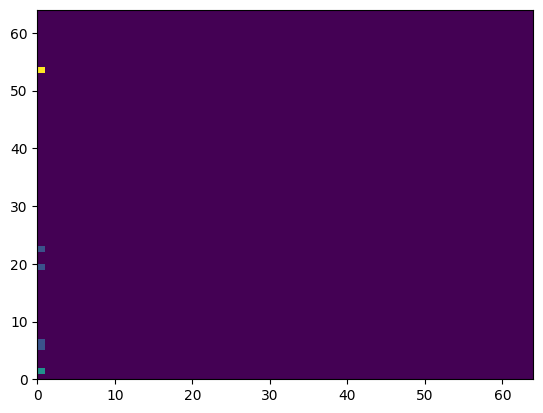

In [ ]:
import matplotlib.pyplot as plt

In [56]:
ranges = []
csv_path = '/home/anatbr/dataset/Allot/ver02 - Location 01 - 2024.09.12-17.csv G Z'
n_rows_per_ds = 1e4
columns = ['timeSec1970', 'timeMs', 'appId', 'ipAddrClient', 'ipAddrServer',
           'portClient', 'portServer', 'protocol', 'ppiLen', 'ppi-pdt',
           'ppi-pd', 'ppi-ps', 'ppi-paux']


for i in trange(500):
    df = pd.read_csv(csv_path, nrows=n_rows_per_ds, skiprows=int(n_rows_per_ds * (i + 1)))
    df.columns = columns
    df['absoluteTime'] = pd.to_datetime(df['timeSec1970'], unit='s')
    assert df.absoluteTime.is_monotonic_increasing
    df.to_csv(f'data/allot_small_csvs/chunks_domain_2/chunk_{i:03d}.csv', index=False)
    # print(df.absoluteTime.min(), df.absoluteTime.max())
    ranges.append((df.absoluteTime.min(), df.absoluteTime.max()))


100%|██████████| 500/500 [23:34<00:00,  2.83s/it]


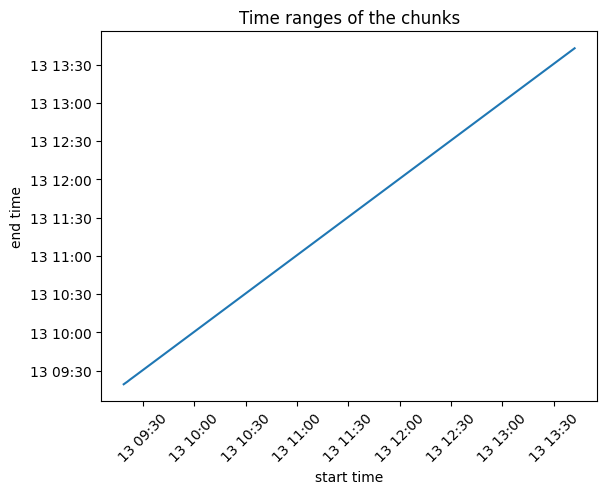

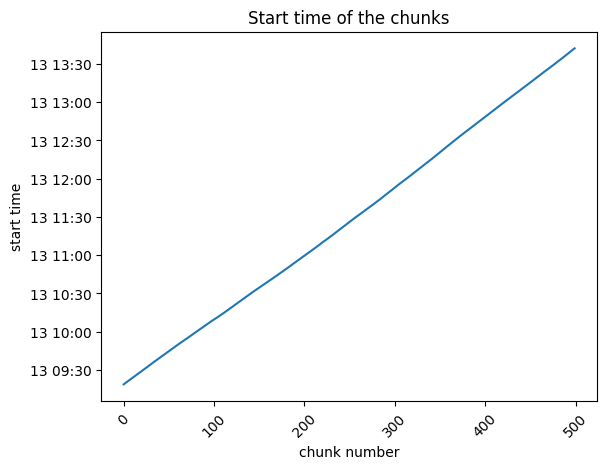

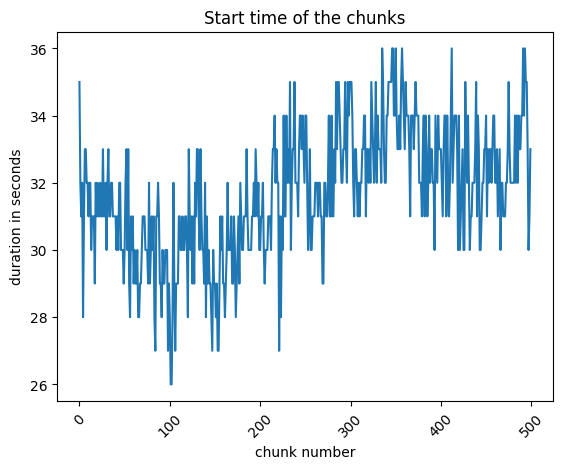

In [57]:
plt.plot([r[0] for r in ranges], [r[1] for r in ranges])
plt.xlabel('start time')
plt.ylabel('end time')
plt.title('Time ranges of the chunks')
plt.xticks(rotation=45)
plt.show()


plt.plot([r[0] for r in ranges])
plt.xlabel('chunk number')
plt.ylabel('start time')
plt.title('Start time of the chunks')
plt.xticks(rotation=45)
plt.show()

plt.plot([(r[1]  - r[0]).total_seconds() for r in ranges])
plt.xlabel('chunk number')
plt.ylabel('duration in seconds')
plt.title('Start time of the chunks')
plt.xticks(rotation=45)
plt.show()


In [ ]:
dfs = []
for i in range(0, 100):
    chunk_path = os.path.join('data', 'allot_small_csvs', 'chunks_domain_1', f'chunk_{i:03}.csv')
    df = pd.read_csv(chunk_path)
    df = df[df['appId'].isin(label_whitelist)]
    dfs.append(df)
df_train = pd.concat(dfs, ignore_index=True)
df_train = df_train.sample(frac=1).reset_index(drop=True)

dfs = []
for i in range(0, 100):
    chunk_path = os.path.join('data', 'allot_small_csvs', 'chunks_domain_2', f'chunk_{i:03}.csv')
    df = pd.read_csv(chunk_path)
    df = df[df['appId'].isin(label_whitelist)]
    dfs.append(df)
df_test = pd.concat(dfs, ignore_index=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)


In [59]:
train_df.appId.hist(alpha=0.5, bins=100, density=True, label='train')
test_df.appId.hist(alpha=0.5, bins=100, density=True, label='test')
plt.legend()
plt.show()

NameError: name 'train_df' is not defined